This challenge serves as final project for the "How to win a data science competition" Coursera course. Data is taken from https://www.kaggle.com/c/competitive-data-science-final-project/data. 

The task is to predict total sales for every product and store in the next month. Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

File descriptions
<ul>
    <li>sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
    <li>test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
    <li>sample_submission.csv - a sample submission file in the correct format.
    <li>items.csv - supplemental information about the items/products.
    <li>item_categories.csv  - supplemental information about the items categories.
    <li>shops.csv- supplemental information about the shops.
</ul>

Data fields
<ul>
    <li>ID - an Id that represents a (Shop, Item) tuple within the test set
    <li>shop_id - unique identifier of a shop
    <li>item_id - unique identifier of a product
    <li>item_category_id - unique identifier of item category
    <li>item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
    <li>item_price - current price of an item
    <li>date - date in format dd/mm/yyyy
    <li>date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
    <li>item_name - name of item
    <li>shop_name - name of shop
    <li>item_category_name - name of item category.
</ul>        

In [194]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler

In [2]:
sales = pd.read_csv('data/sales_train.csv.gz') 
items = pd.read_csv('data/items.csv')
item_categories = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')
test =  pd.read_csv('data/test.csv.gz')

In [3]:
# Sample submission

In [4]:
test.head().append(test.tail())

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [5]:
submission = pd.read_csv('submissions/sample_submission.csv.gz')
submission.head().append(submission.tail())

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5
214199,214199,0.5


In [6]:
# Submission of constant 0.5 gives score 1.23646

In [7]:
# EDA

In [8]:
sales.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [9]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [10]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [11]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [13]:
# No missing values in the data

In [14]:
sales.head().append(sales.tail())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0
2935848,03.10.2015,33,25,7460,299.00,1.0


In [15]:
sales.loc[:,'date'] = pd.to_datetime(sales['date'], format="%d.%m.%Y")

In [16]:
sales['date'].min()

Timestamp('2013-01-01 00:00:00')

In [17]:
sales['date'].max()

Timestamp('2015-10-31 00:00:00')

In [18]:
# transactions df covered the period from Jan 1, 2013 to Oct 31, 2015

In [19]:
sales.sort_values(by=['date','shop_id']).head(50)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
31974,2013-01-01,0,2,11828,1699.0,1.0
32043,2013-01-01,0,2,12134,299.0,1.0
32099,2013-01-01,0,2,6916,999.5,1.0
32129,2013-01-01,0,2,8665,299.0,1.0
32130,2013-01-01,0,2,8712,198.0,1.0
32225,2013-01-01,0,2,16450,399.0,1.0
32348,2013-01-01,0,2,13434,13489.5,1.0
32358,2013-01-01,0,2,6911,599.0,1.0
32367,2013-01-01,0,2,15456,549.0,1.0
32379,2013-01-01,0,2,16162,629.0,1.0


In [20]:
sum(sales['item_cnt_day']==0)

0

In [21]:
sales.groupby('date_block_num').size().describe()

count        34.000000
mean      86348.500000
std       22769.818641
min       50588.000000
25%       72145.250000
50%       87568.000000
75%       98695.750000
max      143246.000000
dtype: float64

In [22]:
# A row in transactions contains data about number of items sold for date/shop_id/item_id, if this number is not 0
# The number of transactions per month is from 50,5k to 143k

In [23]:
# We are to predict monthly sales for shop/item_id for November 2015, date_block_num=34
test.head().append(test.tail())

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [24]:
test.groupby(['shop_id','item_id']).size().sort_values(ascending=False)

shop_id  item_id
2        30         1
42       22007      1
         22145      1
         22154      1
         22162      1
                   ..
22       33         1
         38         1
         42         1
         45         1
59       22167      1
Length: 214200, dtype: int64

In [25]:
# Each row in test df contains unique combination of shop_id/item_id. 
# As number of rows in test is 214k, we can suppose for some rows the prediction can be equal to zero
# That's why it's reasonable to add rows with 0 items sold to train after aggregation via date_block_num/shop_id/item_id


In [26]:
# Let's check consistensy of train and test data

In [27]:
# How many unique item_id are in items, transactions, 
# transactions[transactions['date_block_num']==33] and in test?


In [28]:
print('Number of unique item_id in items df:',len(items['item_id'].unique()))
print('Number of unique item_id in sales df:',len(sales['item_id'].unique()))
print('Number of unique item_id in sales[sales[date_block_num]==33]:',len(sales[sales['date_block_num']==33]['item_id'].unique()))
print('Number of unique item_id in test df:',len(test['item_id'].unique()))


Number of unique item_id in items df: 22170
Number of unique item_id in sales df: 21807
Number of unique item_id in sales[sales[date_block_num]==33]: 5413
Number of unique item_id in test df: 5100


In [29]:
# Are there item_id in test that are not in transactions?
n = test[~test['item_id'].isin(sales['item_id'])]['item_id'].nunique()
print('Number of item_id in test that are not in transactions:', n)

Number of item_id in test that are not in transactions: 363


In [30]:
363/5100

0.0711764705882353

In [31]:
# There are 363 item-id in test that are not in transactions (about 7% of test unique item_id). 

In [32]:
# Are there item_id in transactions for date_block_num==33 that are not in transactions for the rest of the period?
tr = sales[sales['date_block_num']!=33]
val = sales[sales['date_block_num']==33]   

n = val[~val['item_id'].isin(tr['item_id'])]['item_id'].nunique()
print('Number of item_id in val that are not in tr:', n)

Number of item_id in val that are not in tr: 475


In [33]:
475/5413

0.08775170884906706

In [34]:
# Let's create df of transactions aggregated by date_block_num/shop_id/item_id and sum of item_cnt - monthly_sales,
# and research consistency on shop_id 

In [35]:
index_cols = ['date_block_num','shop_id','item_id']
monthly_sales = sales.groupby(index_cols, as_index=False).agg({'item_cnt_day':'sum'}).rename(columns = {'item_cnt_day':'target'})
monthly_sales.sort_values(index_cols, inplace=True)

In [36]:
tr = monthly_sales[monthly_sales['date_block_num']!=33]
val = monthly_sales[monthly_sales['date_block_num']==33]

In [37]:
len(val)

31531

In [38]:
# shop_id
print('Number of unique shop_id in shops df:',len(shops['shop_id'].unique()))
print('Number of unique shop_id in monthly_sales df:',len(monthly_sales['shop_id'].unique()))
print('Number of unique shop_id in test df:',len(test['shop_id'].unique()))
print('Number of unique shop_id in monthly_sales for date_block_num!=33:',len(tr['shop_id'].unique()))
print('Number of unique shop_id in monthly_sales for date_block_num==33:',len(val['shop_id'].unique()))

Number of unique shop_id in shops df: 60
Number of unique shop_id in monthly_sales df: 60
Number of unique shop_id in test df: 42
Number of unique shop_id in monthly_sales for date_block_num!=33: 59
Number of unique shop_id in monthly_sales for date_block_num==33: 44


In [39]:
val[~val['shop_id'].isin(tr['shop_id'])]['shop_id'].unique()

array([36])

In [40]:
shops.loc[36]

shop_name    Новосибирск ТРЦ "Галерея Новосибирск"
shop_id                                         36
Name: 36, dtype: object

In [41]:
shops.head().append(shops.tail())

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
55,Цифровой склад 1С-Онлайн,55
56,"Чехов ТРЦ ""Карнавал""",56
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58
59,"Ярославль ТЦ ""Альтаир""",59


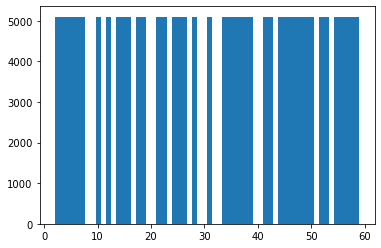

In [42]:
plt.hist(test['shop_id'], bins=60);

In [43]:
test.groupby('shop_id').size().unique()

array([5100])

In [44]:
5100*42

214200

In [45]:
# !!! Now it's clear how test is composed - for each of 5100 unique item_id there is one row for each of 42 shops

# We should compose monthly_sales, tr and val on analogy: for each month find unique shop_id and item_id, 
# add rows with target=0 that is for each month there are all combinations for found shop_id/item_id


In [46]:
# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

index_cols = ['shop_id', 'item_id', 'date_block_num']

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day': 'sum'}).rename(columns = {'item_cnt_day':'target'})

#join aggregated data to the grid
monthly_sales = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)

#sort the data
monthly_sales.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [47]:
tr = monthly_sales[monthly_sales['date_block_num']!=33]
val = monthly_sales[monthly_sales['date_block_num']==33]

In [48]:
len(val)

238172

In [49]:
5413*44

238172

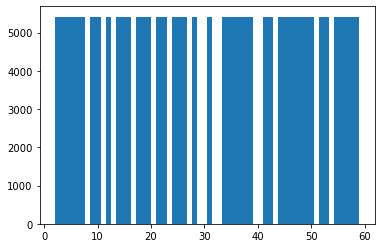

In [50]:
plt.hist(val['shop_id'], bins=60);

In [51]:
# Now val looks consistent with test

In [52]:
# Let's research target and available variables and make hypothesis for feature generation

In [53]:
# We have already considered 2 categorical variables item_id and shop_id. 
# There is one more categorical variable item_category_id. Let's consider it.

In [54]:
# item_category_id 

In [55]:
monthly_sales = monthly_sales.merge(items, how='left', on='item_id')
tr = monthly_sales[monthly_sales['date_block_num']!=33]
val = monthly_sales[monthly_sales['date_block_num']==33]

test = test.merge(items, how='left', on='item_id')

In [56]:
# item_category_id
print('Number of unique item_category_id in item_categories df:',len(item_categories['item_category_id'].unique()))
print('Number of unique item_category_id in monthly_sales df:',len(monthly_sales['item_category_id'].unique()))
print('Number of unique item_category_id in test df:',len(test['item_category_id'].unique()))
print('Number of unique item_category_id in monthly_sales for date_block_num!=33:',len(tr['item_category_id'].unique()))
print('Number of unique item_category_id in monthly_sales for date_block_num==33:',len(val['item_category_id'].unique()))

Number of unique item_category_id in item_categories df: 84
Number of unique item_category_id in monthly_sales df: 84
Number of unique item_category_id in test df: 62
Number of unique item_category_id in monthly_sales for date_block_num!=33: 84
Number of unique item_category_id in monthly_sales for date_block_num==33: 63


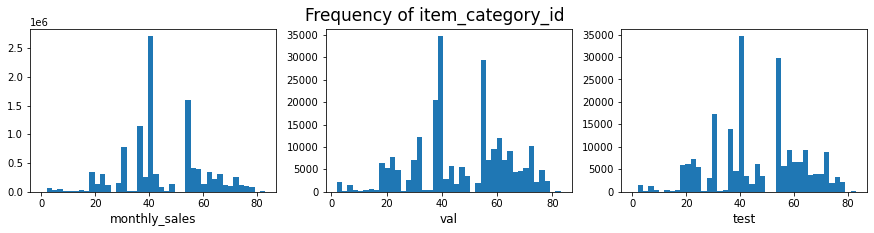

In [57]:
plt.figure(figsize=(15,3))
plt.suptitle("Frequency of item_category_id", fontsize=17)
gridspec.GridSpec(1,3)

plt.subplot2grid((1,3),(0,0))
plt.hist(monthly_sales['item_category_id'], bins=42)
plt.xlabel('monthly_sales', fontsize=12)

plt.subplot2grid((1,3),(0,1))
plt.hist(val['item_category_id'], bins=42)
plt.xlabel('val', fontsize=12)

plt.subplot2grid((1,3),(0,2))
plt.hist(test['item_category_id'], bins=42)
plt.xlabel('test', fontsize=12);

In [58]:
# item_category_id looks very consistent

In [59]:
# !!! 
# For 3 categorical features item_id, shop_id and item_category_id we can try target encoding, 
# e.g. mean and sum of target within the month for a category value
# We can't use target encoding features directly as we don't know target for test data. Instead, we'll use lags of these features. 

# For item_category_id we can also try frequency encoding (within the month)


In [60]:
# target
# According the task, true target values are clipped into [0,20] range

In [61]:
monthly_sales['target'].describe()

count    1.091385e+07
mean     3.342731e-01
std      3.417243e+00
min     -2.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.253000e+03
Name: target, dtype: float64

In [62]:
# As it mentioned above, it's reasonable to try target encoding for categorical variables.
# One way to do it is to clip target first, and then perform target feature encoding and modeling.
# Other approaches to target encoding (e.g. creating features on unclipped target) also can be considered

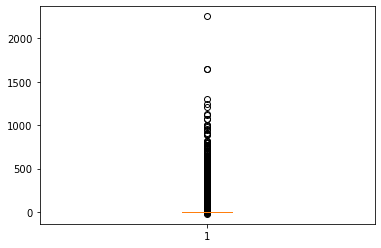

In [63]:
plt.boxplot(monthly_sales['target']);

In [64]:
cl = np.round(sum((monthly_sales['target']>20)|(monthly_sales['target']<0))/len(monthly_sales)*100,1)
print('About {}% of aggegated sales will be clipped'.format(cl))

About 0.1% of aggegated sales will be clipped


In [65]:
# Clip target into [0,20] range

In [66]:
monthly_sales['target_clip'] = monthly_sales['target']
monthly_sales['target_clip'].clip(lower=0, upper=20, inplace=True)

In [67]:
monthly_sales['target_clip'].describe()

count    1.091385e+07
mean     2.982399e-01
std      1.222373e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: target_clip, dtype: float64

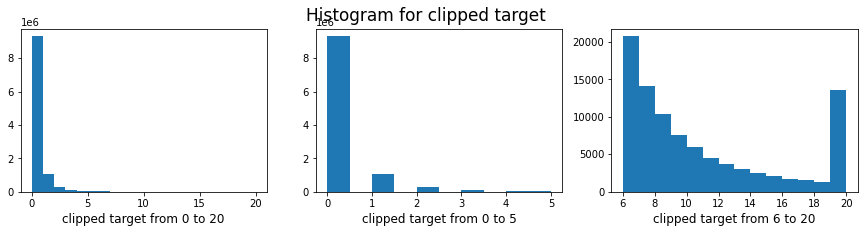

In [68]:
plt.figure(figsize=(15,3))
plt.suptitle("Histogram for clipped target", fontsize=17)
gridspec.GridSpec(1,3)

plt.subplot2grid((1,3),(0,0))
plt.hist(monthly_sales['target_clip'], bins=20)
plt.xlabel('clipped target from 0 to 20', fontsize=12)

plt.subplot2grid((1,3),(0,1))
plt.hist(monthly_sales[monthly_sales['target_clip']<=5]['target_clip'])
plt.xlabel('clipped target from 0 to 5', fontsize=12)

plt.subplot2grid((1,3),(0,2))
plt.hist(monthly_sales[monthly_sales['target_clip']>5]['target_clip'], bins=14)
plt.xlabel('clipped target from 6 to 20', fontsize=12);

In [69]:
# Let's consider relationship of clipped target with time

In [70]:
# Visualize sum and mean of monthly sales

In [71]:
ms = monthly_sales.groupby('date_block_num')['target_clip'].agg(['sum', 'mean'])

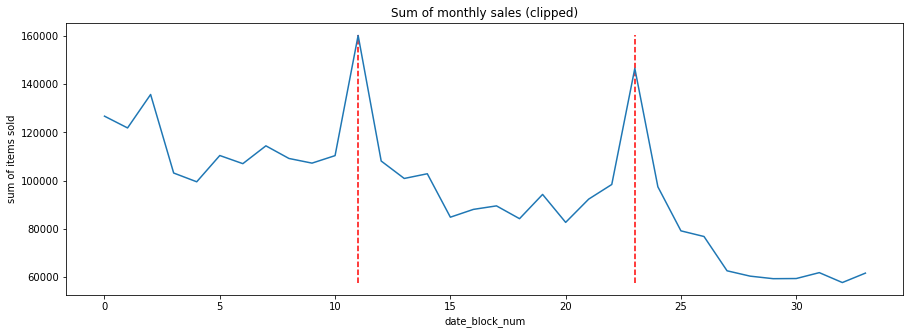

In [72]:
# Plot it
plt.figure(figsize=(15,5))
plt.plot(ms['sum'].index, ms['sum'].values)
plt.vlines(x=[11,23], ymin=ms['sum'].values.min(), ymax=ms['sum'].values.max(), colors='red', ls='--')
plt.ylabel('sum of items sold')
plt.xlabel('date_block_num')
plt.title("Sum of monthly sales (clipped)")
plt.show();

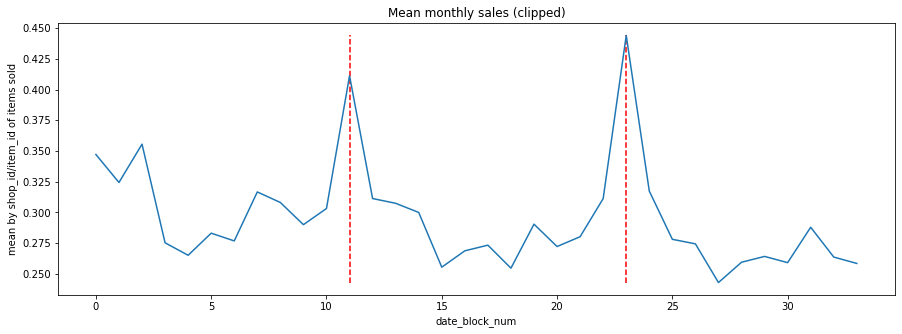

In [73]:
# Plot it
plt.figure(figsize=(15,5))
plt.plot(ms['mean'].index, ms['mean'].values)
plt.vlines(x=[11,23], ymin=ms['mean'].values.min(), ymax=ms['mean'].values.max(), colors='red', ls='--')
plt.ylabel('mean by shop_id/item_id of items sold')
plt.xlabel('date_block_num')
plt.title("Mean monthly sales (clipped)")
plt.show();

In [74]:
# The chart shows yearly seasonality

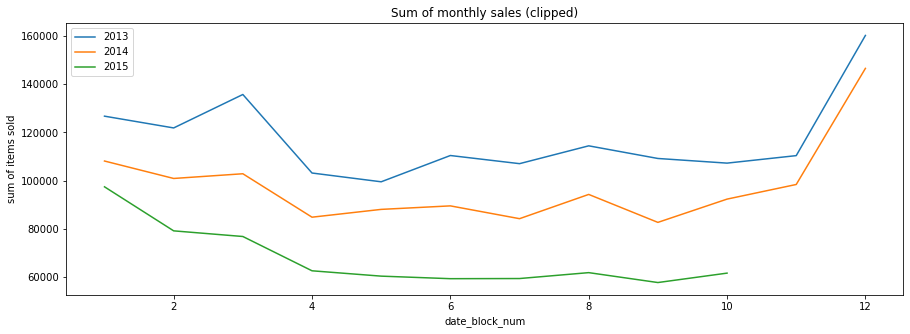

In [75]:
# Plot separate lines for sum
plt.figure(figsize=(15,5))
plt.plot(np.arange(1,13), ms['sum'].values[:12], label='2013')
plt.plot(np.arange(1,13), ms['sum'].values[12:24], label='2014')
plt.plot(np.arange(1,11), ms['sum'].values[24:], label='2015')
plt.legend()
plt.ylabel('sum of items sold')
plt.xlabel('date_block_num')
plt.title("Sum of monthly sales (clipped)")
plt.show();

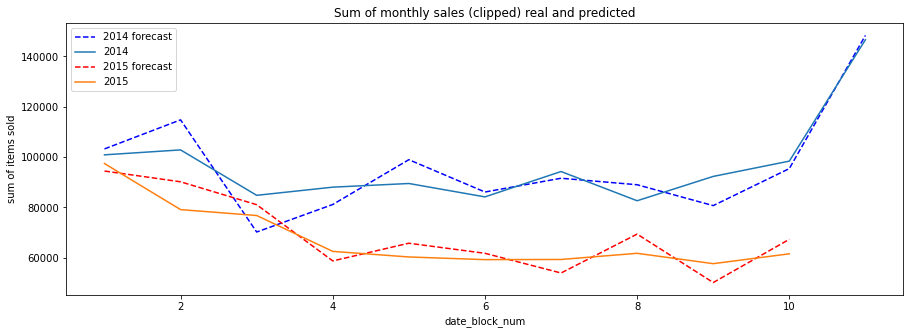

In [76]:
# Let's see how well sum of monthly sales from Feb 2014 till Oct 2015 will be predicted by 
# sum of monthly sales with lag -12 and difference between sum of monthly sales with lags -13 and -1

plt.figure(figsize=(15,5))

d1 = ms['sum'].values[:12] - ms['sum'].values[12:24] # diff between 2013 and 2014
plt.plot(np.arange(1,12), ms['sum'].values[1:12]-d1[:11], color='blue', ls='--', label='2014 forecast')
plt.plot(np.arange(1,12), ms['sum'].values[13:24], label='2014')

d2 = ms['sum'].values[11:21] - ms['sum'].values[23:33] # diff between 2014 and 2015
plt.plot(np.arange(1,11), ms['sum'].values[12:22]-d2, color='red', ls='--', label='2015 forecast')
plt.plot(np.arange(1,11), ms['sum'].values[24:], label='2015')

plt.legend()
plt.ylabel('sum of items sold')
plt.xlabel('date_block_num'), 
plt.title("Sum of monthly sales (clipped) real and predicted")
plt.show();

In [77]:
# The prediction is quite good, so such a feature can be considered

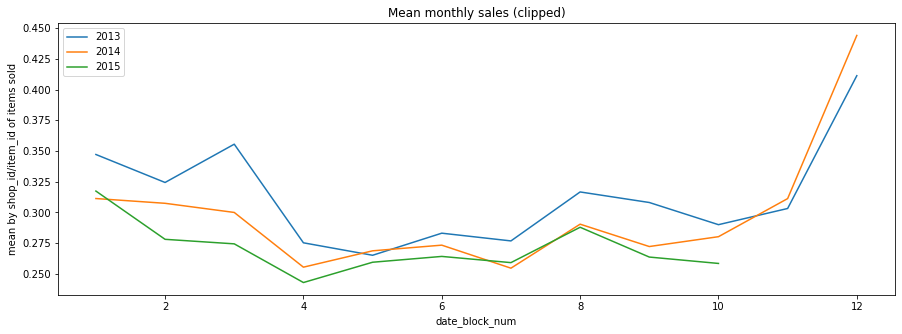

In [78]:
# Plot mean monthly sales
plt.figure(figsize=(15,5))
plt.plot(np.arange(1,13), ms['mean'].values[:12], label='2013')
plt.plot(np.arange(1,13), ms['mean'].values[12:24], label='2014')
plt.plot(np.arange(1,11), ms['mean'].values[24:], label='2015')
plt.legend()
plt.ylabel('mean by shop_id/item_id of items sold')
plt.xlabel('date_block_num')
plt.title("Mean monthly sales (clipped)")
plt.show();

In [79]:
# Sum and mean of monthly sales have yearly sesonality and 
# line for next year, in the main, is lower than for the previous one.
# That's it's reasonable to try as features sum and mean monthly sales with lags 
# -1, -2, -3, -12 and lag -12 -(difference between -13 and -1), it also can be considered 
# differences between lags -3 and -2, -2 and -1

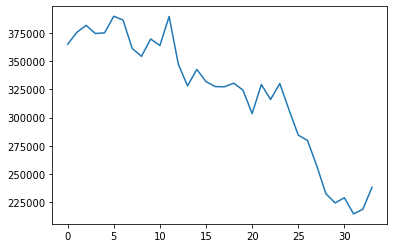

In [80]:
# Number of rows in monthly sales for each date_block_num
n = monthly_sales.groupby('date_block_num').size()
plt.plot(n.index, n.values);

In [81]:
# n also can be tryed as a feature

In [82]:
# Visualize mean of monthly sales by shop

In [83]:
ms = monthly_sales.groupby(['date_block_num','shop_id'])['target_clip'].agg('mean')
ms = ms.unstack('shop_id')
ms.head()

shop_id,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
date_block_num,,,,,,,,,,,,,,,,,,,,,
0,0.666790,0.361306,0.141220,0.094516,0.257425,NaN,0.438817,0.305853,0.180283,NaN,...,0.412323,0.315712,0.220949,0.251263,1.038324,NaN,0.395810,NaN,NaN,0.246827
1,0.712537,0.405730,0.059868,0.097698,0.244736,0.107370,0.460823,0.305093,0.141528,NaN,...,0.369368,0.264202,0.211068,0.230167,0.873164,NaN,0.320274,NaN,NaN,0.228820
2,NaN,NaN,0.090460,0.115514,0.243435,0.163214,0.482775,0.285112,0.117923,NaN,...,0.409660,0.299325,0.237413,0.273428,0.995302,NaN,0.368947,0.753312,0.447242,0.237533
3,NaN,NaN,0.071823,0.079435,0.035236,0.123757,0.374954,0.189073,0.000000,NaN,...,0.330632,0.227993,0.175322,0.184039,0.764027,NaN,0.264088,0.650092,0.346839,0.169061
4,NaN,NaN,0.066315,0.084423,0.144502,0.132750,0.349442,0.192229,NaN,NaN,...,0.335052,0.252428,0.168485,0.195707,0.738098,0.098933,0.252668,0.602710,0.276652,0.150018


In [84]:
ms.dropna(axis=1, how='any', inplace=True)
ms.head()

shop_id,2,3,4,6,7,12,14,15,16,18,...,42,44,45,46,47,50,52,53,56,59
date_block_num,,,,,,,,,,,,,,,,,,,,,
0,0.141220,0.094516,0.257425,0.438817,0.305853,0.097104,0.217991,0.321873,0.365742,0.345410,...,0.477018,0.209119,0.198644,0.400986,0.257917,0.412323,0.220949,0.251263,0.395810,0.246827
1,0.059868,0.097698,0.244736,0.460823,0.305093,0.129407,0.212292,0.318683,0.315010,0.392875,...,0.451028,0.223555,0.185357,0.315377,0.221841,0.369368,0.211068,0.230167,0.320274,0.228820
2,0.090460,0.115514,0.243435,0.482775,0.285112,0.141050,0.219827,0.312214,0.360275,0.391954,...,0.519995,0.247049,0.217177,0.351120,0.233558,0.409660,0.237413,0.273428,0.368947,0.237533
3,0.071823,0.079435,0.035236,0.374954,0.189073,0.151136,0.153223,0.262738,0.259300,0.293554,...,0.458564,0.197422,0.152855,0.260773,0.186863,0.330632,0.175322,0.184039,0.264088,0.169061
4,0.066315,0.084423,0.144502,0.349442,0.192229,0.097734,0.163209,0.223528,0.252069,0.317784,...,0.409881,0.160931,0.149538,0.269457,0.192349,0.335052,0.168485,0.195707,0.252668,0.150018


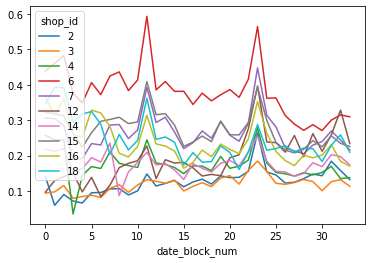

In [85]:
ms.iloc[:,:10].plot.line();

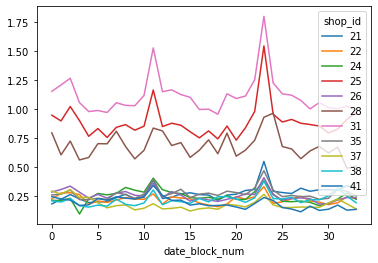

In [86]:
ms.iloc[:,11:22].plot.line();

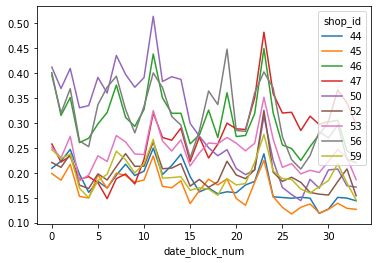

In [87]:
ms.iloc[:,23:].plot.line();

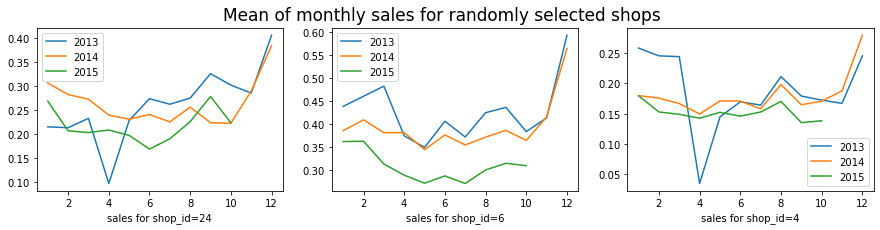

In [88]:
n = 3
plt.figure(figsize=(15,3))
plt.suptitle("Mean of monthly sales for randomly selected shops", fontsize=17)
gridspec.GridSpec(1,n)

col_ind = np.random.randint(len(ms.columns)-1, size=n)

for i in range(n):
    ind = col_ind[i]
    plt.subplot2grid((1,n),(0,i))
    plt.plot(np.arange(1,13), ms.iloc[:, ind].values[:12], label='2013')
    plt.plot(np.arange(1,13), ms.iloc[:, ind].values[12:24], label='2014')
    plt.plot(np.arange(1,11), ms.iloc[:, ind].values[24:], label='2015')
    plt.legend()
    plt.xlabel('sales for shop_id='+ str(ms.columns[ind]))

In [89]:
# Mean of monthly sales by shop in most cases has yearly seasonality, 
# so it's reasonable to try features in the way we suggested for sum and mean 
# of monthly sales (see above)

In [ ]:
# We didn't visualize mean of monthly sales by item_id as there are more than 20k item_id in sales.
# We can assume yearly seasonality of mean monthly sales by item_id and try features similar to ones for mean of monthly sales by shop.

In [90]:
# Visualize mean of monthly sales by category

In [91]:
ms = monthly_sales.groupby(['date_block_num','item_category_id'])['target_clip'].agg('mean')
ms = ms.unstack('item_category_id')
ms.head()

item_category_id,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
date_block_num,,,,,,,,,,,,,,,,,,,,,
0,0.022222,0.022222,0.835435,4.422222,0.513131,0.513580,1.017544,NaN,NaN,0.311111,...,NaN,0.631111,NaN,0.249096,NaN,3.222222,NaN,0.655556,3.279365,3.055556
1,0.021739,0.021739,0.615942,6.239130,0.478261,0.300167,0.685300,NaN,NaN,0.273913,...,NaN,0.557312,NaN,0.212879,NaN,2.782609,NaN,0.804348,3.420290,1.535326
2,NaN,NaN,0.571906,3.043478,0.548309,0.320652,0.736842,NaN,NaN,0.360870,...,NaN,0.551857,NaN,0.260870,NaN,5.456522,NaN,0.384058,3.394928,3.489130
3,0.021739,NaN,0.379553,4.347826,0.434783,0.239130,0.505435,NaN,NaN,0.375000,...,NaN,0.458859,NaN,0.171304,NaN,2.043478,NaN,0.625000,2.565217,2.200000
4,NaN,NaN,0.340741,1.622222,0.388889,0.260185,0.426087,NaN,NaN,0.355556,...,NaN,0.404651,0.07619,0.147425,0.030453,1.844444,NaN,0.627778,3.540741,2.320000


In [92]:
ms.dropna(axis=1, how='any', inplace=True)
ms.head()

item_category_id,2,3,5,6,9,11,14,15,19,21,...,67,69,70,71,72,73,75,77,79,83
date_block_num,,,,,,,,,,,,,,,,,,,,,
0,0.835435,4.422222,0.513580,1.017544,0.311111,0.491503,0.453968,0.372222,0.835177,0.970556,...,0.258907,0.255026,0.753535,1.377778,0.250415,0.819753,0.631111,0.249096,3.222222,3.055556
1,0.615942,6.239130,0.300167,0.685300,0.273913,0.342029,0.338509,0.344720,0.894579,0.822609,...,0.282921,0.231096,0.692547,0.079710,0.197659,0.772826,0.557312,0.212879,2.782609,1.535326
2,0.571906,3.043478,0.320652,0.736842,0.360870,0.300725,0.316770,0.269022,1.093738,0.828437,...,0.231044,0.269410,0.677640,0.130435,0.173913,0.706994,0.551857,0.260870,5.456522,3.489130
3,0.379553,4.347826,0.239130,0.505435,0.375000,0.312112,0.195652,0.173913,0.688007,0.601134,...,0.177317,0.191094,0.616119,1.945652,0.128645,0.685771,0.458859,0.171304,2.043478,2.200000
4,0.340741,1.622222,0.260185,0.426087,0.355556,0.208333,0.311111,0.170833,0.672855,0.703268,...,0.145265,0.209829,0.760131,7.400000,0.137676,0.443478,0.404651,0.147425,1.844444,2.320000


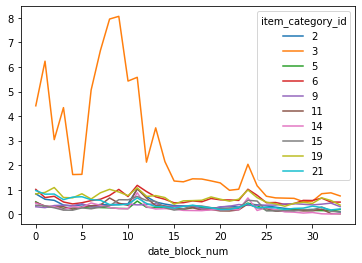

In [93]:
ms.iloc[:,:10].plot.line();

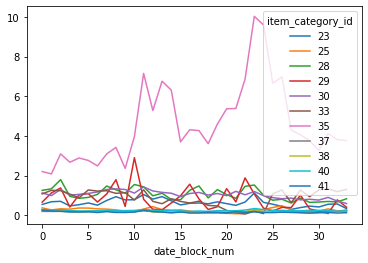

In [94]:
ms.iloc[:,11:22].plot.line();

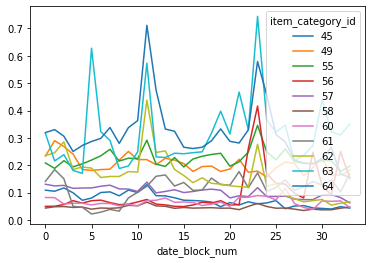

In [95]:
ms.iloc[:,23:34].plot.line();

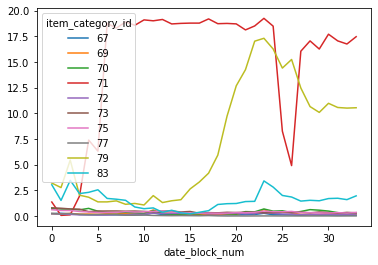

In [96]:
ms.iloc[:,35:].plot.line();

In [97]:
# Mean of monthly sales by item_category in most cases has weak yearly seasonality,
# so it's reasonable to try as features lags of -1,-2,-3 and differences between lags -1 and -2, -2 and -3

In [98]:
# Let's consider item_price 

In [99]:
sales['item_price'].describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

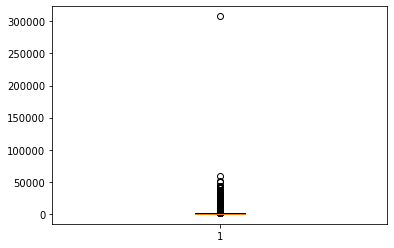

In [100]:
plt.boxplot(sales['item_price']);

In [101]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [102]:
temp = pd.merge(sales, items, how='left', on='item_id')
temp.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56


In [103]:
temp[(temp['item_price']<0) | (temp['item_price']>100000)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
484683,2013-05-15,4,32,2973,-1.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19
1163158,2013-12-13,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75


In [104]:
temp[(temp['item_id']==2973)&(temp['shop_id']==32)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
67427,2013-01-29,0,32,2973,2499.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19
67428,2013-01-25,0,32,2973,2499.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19
67429,2013-01-22,0,32,2973,2499.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19
67430,2013-01-21,0,32,2973,2499.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19
67431,2013-01-18,0,32,2973,2499.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19
67432,2013-01-17,0,32,2973,2499.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19
67433,2013-01-15,0,32,2973,2499.0,3.0,"DmC Devil May Cry [PS3, русские субтитры]",19
187844,2013-02-05,1,32,2973,2499.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19
187845,2013-02-14,1,32,2973,2499.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19
484682,2013-05-23,4,32,2973,1249.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19


In [105]:
# Let's change the price of -1 to 2499.0
temp.loc[temp['item_price']<0, 'item_price'] = 2499.0

In [106]:
temp[temp['item_id']==6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
1163158,2013-12-13,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75


In [107]:
# Let's drop the row with price 307980.0 as it's outlier and no more rows with item_id 6066 neither in sales no in test
temp.drop(index=temp[temp['item_id']==6066].index, inplace=True)


In [108]:
# Research relationships between price and target

In [161]:
t = temp.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({'item_price':'mean', 'item_cnt_day':'sum'})\
.rename(columns = {'item_cnt_day':'target'})
t['target'].clip(lower=0, upper=20, inplace=True)
t.head()


,date_block_num,shop_id,item_id,item_price,target
0,0,0,32,221.0,6.0
1,0,0,33,347.0,3.0
2,0,0,35,247.0,1.0
3,0,0,43,221.0,1.0
4,0,0,51,128.5,2.0


In [162]:
t['item_price'].describe()

count    1.609123e+06
mean     7.906943e+02
std      1.532592e+03
min      9.000000e-02
25%      1.990000e+02
50%      3.990000e+02
75%      8.985000e+02
max      5.099900e+04
Name: item_price, dtype: float64

In [163]:
print('0.99 quantile', t['item_price'].quantile(0.99))

0.99 quantile 5690.0


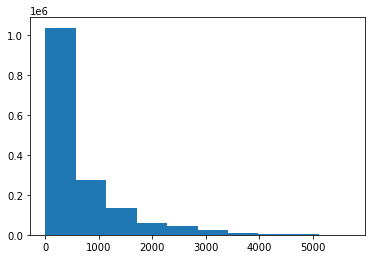

In [165]:
plt.hist(t.loc[t['item_price']<5690, 'item_price']);

In [166]:
# Mean aggregated prices have median 400 and 75% of values less than 900.

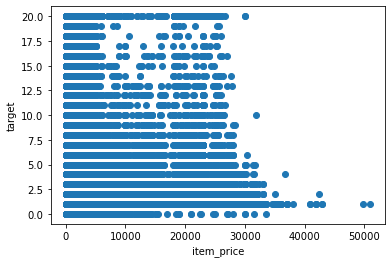

In [170]:
plt.scatter(t['item_price'], t['target'])
plt.xlabel('item_price')
plt.ylabel('target')
plt.show();

In [171]:
tt = t[t['item_price']<5960]

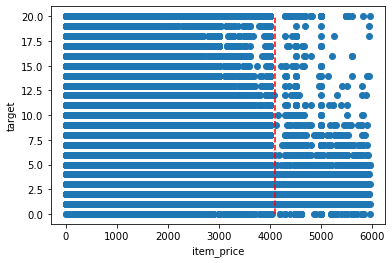

In [191]:
plt.scatter(tt['item_price'], tt['target'])
plt.vlines(x=[4100], ymin=0, ymax=20, colors='red', ls='--')
plt.xlabel('item_price')
plt.ylabel('target')
plt.show();

In [ ]:
# It looks like for prices less than 4050, target distributions are about the same for all prices values
# For prices higher than 4050, target values are mostly less than 8-9. 

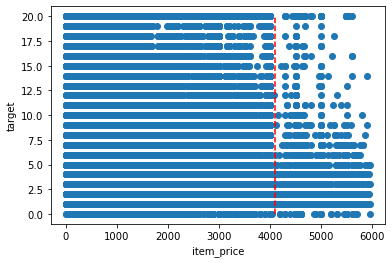

In [192]:
tt_ = t[(t['item_price']<5960)&(t['date_block_num']>11)] # from January 2014
plt.scatter(tt_['item_price'], tt_['target'])
plt.vlines(x=[4100], ymin=0, ymax=20, colors='red', ls='--')
plt.xlabel('item_price')
plt.ylabel('target')
plt.show();

In [193]:
# It looks about the same for the period from Jan 2014 (this period can be considered for training,
# as year 2013 can be used to create lag vars)

# It's reasonable to try binary feature if mean item price (aggregated as above) more or less that 4100

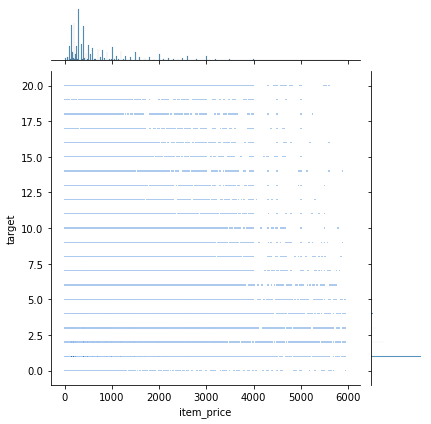

In [183]:
sns.jointplot(x='item_price', y='target', data=tt_, kind='hist');

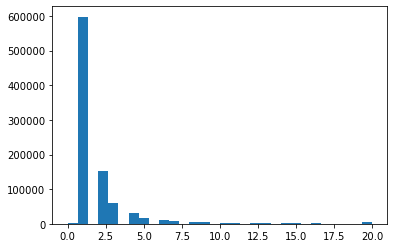

In [184]:
plt.hist(tt_['target'], bins=30);

In [ ]:
# Most frequent target value for item of any price is 1.

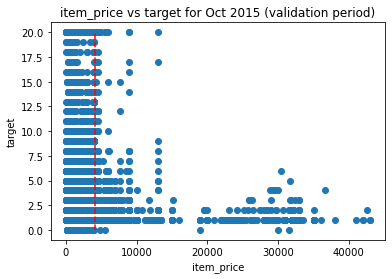

In [190]:
t33=t[t['date_block_num']==33]
plt.scatter(t33['item_price'], t33['target'])
plt.vlines(x=[4100], ymin=0, ymax=20, colors='red', ls='--')
plt.xlabel('item_price')
plt.ylabel('target')
plt.title('item_price vs target for Oct 2015 (validation period)')
plt.show();

In [1]:
# But we don't have prices in test df and we have 363 item-id in test that are not in transactions (about 7% of test unique item_id)
# So, we can consider mean item price for a previous period (lag 1). For cases when there is no item in transactions for considered period,
# the feature value can be set to -1.


In [ ]:
# Conclusions from EDA

In [ ]:
# Test composition
# We've understood how test is composed and we should compose training and validation datasets on analogy: for each month find unique shop_id and item_id, 
# add rows with target=0 that is for each month there are all combinations for found shop_id/item_id


In [ ]:
# Validation scheme
# We've chosen validation scheme: Oct 2015 (date_block_num=13) for validation, the rest of the data from Jan 2014 for training. Year 2013 can be used for lag features creation. 
# After validation step, we'll retrain model on train+valid to predict on test.
# We checked consistency of item_id and shop_id in training, validation and test data.


In [ ]:
# Missing values
# There is no missing values

In [ ]:
# Data preprocessing
# Convert data to datetime format
# We'll change the price of -1 to 2499.0 (one row) and drp a tranaction and
# drop the row with price 307980.0 as it's outlier and no more rows with item_id 6066 neither in sales no in test

In [ ]:
# Categorical features encoding
# For 3 categorical features item_id, shop_id and item_category_id we can try target encoding, 
# e.g. mean and sum of target within the month for a category value.

# We can't use target encoding features directly as we don't know target for test data. Instead, we'll use lags of these features. 

# For item_category_id we can also try frequency encoding (within the month)

# Sum and mean of monthly sales have yearly sesonality and 
# line for next year, in the main, is lower than for the previous one.
# That's reasonable to try as features sum and mean monthly sales with lags 
# -1, -2, -3, -12 and lag -12 -(difference between lags -13 and -1), it also can be considered 
# differences between lags -3 and -2, -2 and -1

# Mean of monthly sales by shop in most cases has yearly seasonality, 
# so it's reasonable to try features in the way we suggested for sum and mean 
# of monthly sales (see above)

# We didn't visualize mean of monthly sales by item_id as there are more than 20k item_id in sales.
# We can assume yearly seasonality of mean monthly sales by item_id and try features similar to ones for mean of monthly sales by shop.

# Mean of monthly sales by item_category in most cases has weak yearly seasonality,
# so it's reasonable to try as features lags of -1,-2,-3 and differences between lags -1 and -2, -2 and -3

In [ ]:
# More ideas of feature enfineering

# Crete feature month (extract from data)

# Number of rows for date_block_num in monthly sales 

# It's reasonable to try a lag 1 of a binary feature based on mean item price aggregated by date_block_num/item_id. 
# Distribution of target looks different for items with prices less and higher 4100. As we don't have prices for test, we can use lag of this feature.

# There is also 3 text variables (shop_name, item_name, item_category_name). We can try the following: preprocessing (stemming, stop words removal etc.) and tf-idf and/or word-to-vec encoding 
